In [3]:
%load_ext jupyternotify
%load_ext autotime

<IPython.core.display.Javascript object>

# About сompetition

https://www.kaggle.com/c/understanding_cloud_organization

# Load Modules

In [1]:
from datetime import datetime

import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.offsetbox import AnchoredText

import cv2

import keras
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


# Constants

In [5]:
dataset_dir = 'understanding_cloud_organization'
train_data = os.path.join(dataset_dir, 'train.csv')
train_images = os.path.join(dataset_dir, 'train_images')

time: 419 µs


In [6]:
df = pd.read_csv(train_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 2 columns):
Image_Label      22184 non-null object
EncodedPixels    11836 non-null object
dtypes: object(2)
memory usage: 346.7+ KB
time: 3.29 s


In [7]:
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


time: 4.63 ms


# Helpers

In [8]:
# https://www.kaggle.com/shahules/understanding-clounds-with-keras-unet#kln-144
def build_mask(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if isinstance(rle, str):
            
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = cv2.resize(mask, reshape[::-1])
                masks[:, :, i] = reshaped_mask
    
    return masks
        
def rle2mask(rle_strig, input_shape, reshape=None):

    rle = rle_strig.split(' ')
    cols, rows = input_shape[:2]

    #создаем вектор, длиной равной размерности исходного изображения, т.к. EncodedPixels это вектор
    mask= np.zeros(cols*rows).astype(np.uint8)

    #интирую строковые данные
    array = np.asarray([int(n) for n in rle])

    # четные описывают позицию px, нечетные длину ребра px
    starts, lengths = array[0::2], array[1::2]
    ends = starts+lengths-1 # чтобы исключить последний элемент в длине
    pairs = np.column_stack([starts, ends])

    for pos, length in pairs:
        mask[pos:length] = 255

    mask = mask.reshape(rows, cols).T

    if reshape:
        mask = cv2.resize(mask, reshape[::-1])

    return mask

def show_bar(ax):
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x(), 1.01*p.get_height()))

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def has_black_area(img_name):
    img_name = np.unique([i.split('_')[0] for i in img_name])[0]
    img_path = os.path.join(train_images, img_name)
    img = cv2.imread(img_path)
    
    black = np.where((img==[0,0,0]).all(axis=2))
    if np.any(black):
        return True
    else:
        return False

def get_black_area(img_name):
    img_name = np.unique([i.split('_')[0] for i in img_name])[0]
    img_path = os.path.join(train_images, img_name)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    
    ret,th1 = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY)
    th2 = cv2.bitwise_not(th1)
    return th2

def mask2contour(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = [ cnt[:,0,:] for cnt in contours]
    return cnts

def show_img_mask(series, INFO=True):
    
    labels = [i.split('_')[-1] for i in series.Images]

    img_name = np.unique([i.split('_')[0] for i in series.Images])[0]
    img_path = os.path.join(train_images, img_name)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    mask_rle = {l:rows for l, rows in zip(labels, series.EncodedPixels) if isinstance(rows, str)}
    
    if INFO:
        print(f'[INFO] img_name: {img_name}')
        print(f'[INFO] shape: {img.shape}')
        print(f'[INFO] count_mask: {len(mask_rle)}')
        print(f'[INFO] labels: {list(mask_rle.keys())}')

    conf_img = {'Fish': [0,0, 1, .3], # RGBA
                'Flower': [0, 1, 0, .3],
                'Sugar': [1,0, 0, .3],
                'Gravel': [1, 0.6,0, .3]}

    count_label = len(mask_rle)

    fig, ax = plt.subplots(nrows=count_label, ncols=3, figsize=(15,10), constrained_layout=False)
    
    if count_label == 1:
        ax = ax[np.newaxis, ...]
    
    for cnt, (k,v) in enumerate(mask_rle.items()):
        mask = rle2mask(v, img.shape)

        resize_shape = (525, 350)
        img_resize = cv2.resize(img, resize_shape)
        mask = cv2.resize(mask, resize_shape)

        ax[cnt, 0].imshow(img_resize)
        ax[cnt, 0].set_title('{} | {}'.format(img_name, k))
        ax[cnt, 0].axis('off')

        ax[cnt, 1].imshow(mask)
        ax[cnt, 1].set_title('Origin mask | {}'.format(k))
        ax[cnt, 1].axis('off')

        compose_img(img_resize, mask, ax[cnt, 2], k)

    
def compose_img(img, mask, ax, label):
    
    conf_img = {'Fish': [0,0, 1, .3], # RGBA
                'Flower': [0, 1, 0, .3],
                'Sugar': [1,0, 0, .3],
                'Gravel': [1, 0.6,0, .3]}
    
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, 
                           cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=10)
    
    cnts = mask2contour(opening)
    for cnt in cnts:
        x1, y1 = np.min(cnt, axis=0)
        edgecolor=np.array(conf_img[label]) + [0, 0, 0, 0.7]
        poly = Polygon(cnt, edgecolor=edgecolor, facecolor=conf_img[label], linestyle="dashed", linewidth=2)

        ax.add_patch(poly)
        ax.text(x1+10, y1+40, label, color='black', size=11, backgroundcolor=edgecolor)
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('{} | {}'.format(img_name, label))
    
    return ax

def show_img(img_name):
    labels = [i.split('_')[-1] for i in series.Images]
    img_name = np.unique([i.split('_')[0] for i in series.Images])[0]
    
    img_path = os.path.join(train_images, img_name)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,10))
    plt.imshow(img)


time: 9.13 ms


# EDA

## Understanding number of Masks

In [9]:
df['ImageID'] = df['Image_Label'].apply(lambda x: x.split('_')[0].strip('.jpg'))
df['Label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])
df['Hasmask'] = df['EncodedPixels'].notnull()

time: 27.4 ms


In [10]:
df.head()

,Image_Label,EncodedPixels,ImageID,Label,Hasmask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165,Flower,True
2,0011165.jpg_Gravel,NaN,0011165,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f,Fish,True


time: 6.33 ms


In [11]:
total = len(df.ImageID.unique())
print('Всего снимков - ',total,'\n')
print('Всего масок - ', df.Hasmask.sum(), '\n')

Всего снимков -  5546 

Всего масок -  11836 

time: 11.6 ms


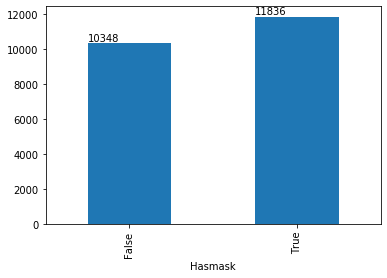

time: 158 ms


In [12]:
hasmask_count = df.groupby('Hasmask')['ImageID'].count()

ax = hasmask_count.plot.bar()
show_bar(ax)

* Из графика следует, что в среднем снимок имеет около двух масок, так как разница в количестве True и False по отношению HasMask на изображении не велика

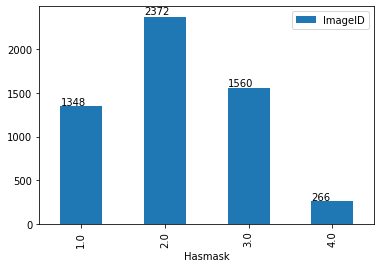

time: 127 ms


In [13]:
count_mask = df.groupby('ImageID').agg(sum).reset_index().sort_values('Hasmask', ascending=False)

ax = count_mask.groupby('Hasmask').count().plot.bar()
show_bar(ax)

* гипотеза о преобладание двух масок на снимок подтвержается  

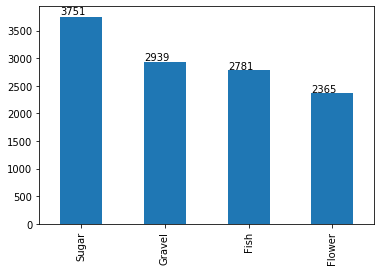

time: 111 ms


In [14]:
ax = df[df['Hasmask']].Label.value_counts().plot.bar()
show_bar(ax)

* По гистограмме прослеживается преобладание класса Sugar. 

`Надо провести небольшое преобразование данных, для дальнейшего анализа и лучшего понимания данных. Следует также оценить взаимодействие облачных образований междусобой`.

## Ohe the Labels

* Проведем унитарное кодирование лейблов - one hot encode the Labels

In [15]:
# `dummies`  - `манекены` ?  P.S. Фиктивные переменные 
df_ohe = pd.get_dummies(df, columns = ['Label'])

# Последние 4 столбца (labels) умножаю на Hasmask, чтобы обнулить строки у Label`ов, где Hasmask==False
df_ohe.iloc[:, -4:] = df_ohe.iloc[:, -4:].apply(lambda x: x * df['Hasmask'].astype(int))
df_ohe.head()

,Image_Label,EncodedPixels,ImageID,Hasmask,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165,True,1,0,0,0
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165,True,0,1,0,0
2,0011165.jpg_Gravel,NaN,0011165,False,0,0,0,0
3,0011165.jpg_Sugar,NaN,0011165,False,0,0,0,0
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f,True,1,0,0,0


time: 33.5 ms


In [16]:
# Теперь можно удалить строки, где Hasmask == False, т.к. в Label`ах эта инфа уже отражена
# df_ohe = df_ohe[df_ohe.Hasmask]
# df_ohe.head()

time: 178 µs


* Нужно отформатировать таблицу по ImadeID для лучшего восприятия и работы с данными

## Aggregation

In [17]:
# агрегация сгруппирированных по ImageID cтрок в списки
df_by_id = df_ohe.groupby('ImageID').agg(list)
df_by_id.head()

,Image_Label,EncodedPixels,Hasmask,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
ImageID,,,,,,,
0011165,"[0011165.jpg_Fish, 0011165.jpg_Flower, 0011165...",[264918 937 266318 937 267718 937 269118 937 2...,"[True, True, False, False]","[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]"
002be4f,"[002be4f.jpg_Fish, 002be4f.jpg_Flower, 002be4f...",[233813 878 235213 878 236613 878 238010 881 2...,"[True, True, False, True]","[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 1]"
0031ae9,"[0031ae9.jpg_Fish, 0031ae9.jpg_Flower, 0031ae9...",[3510 690 4910 690 6310 690 7710 690 9110 690 ...,"[True, True, False, True]","[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 1]"
0035239,"[0035239.jpg_Fish, 0035239.jpg_Flower, 0035239...","[nan, 100812 462 102212 462 103612 462 105012 ...","[False, True, True, False]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 0]"
003994e,"[003994e.jpg_Fish, 003994e.jpg_Flower, 003994e...",[2367966 18 2367985 2 2367993 8 2368002 62 236...,"[True, False, True, True]","[1, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]"


time: 2.51 s


## Transformation columns

In [18]:
# Изменить Hasmask в CountMask
df_by_id['Hasmask'] = df_by_id.Hasmask.apply(lambda x: sum(x))
df_by_id.rename(columns={'Hasmask':'CountMask'}, inplace=True)

time: 4.91 ms


In [19]:
# Переименую столбцы c Label в исходные наименования классов (Fish,Flowe,Gravel,Sugar)
label_names = [i.split('Label_')[-1] for i in df_ohe.columns[-4:]]
df_by_id.rename(columns={ prev:new for prev, new in zip(df_ohe.columns[-4:], label_names) }, inplace=True)

time: 8.69 ms


In [20]:
# Преобразование столбцов Label из list в int
l = df_by_id.iloc[:, -4:].columns # Fish, Flower, Gravel, Sugar
names = {num:label for num, label in enumerate(l)}
df_by_id.iloc[:, -4:] = df_by_id.iloc[:, -4:].apply(lambda x: pd.Series([max(i) for i in x]), axis=1)\
                                            .rename(columns=names)

# Изменить Image_Label на Images для удобства, и оставим только название файла
df_by_id.rename(columns={'Image_Label':'Images'}, inplace=True)
# df_by_id['Images'] = df_by_id.Images.apply(lambda x: np.unique([i.split('_')[0] for i in x])[0])
df_by_id.head()

,Images,EncodedPixels,CountMask,Fish,Flower,Gravel,Sugar
ImageID,,,,,,,
0011165,"[0011165.jpg_Fish, 0011165.jpg_Flower, 0011165...",[264918 937 266318 937 267718 937 269118 937 2...,2,1,1,0,0
002be4f,"[002be4f.jpg_Fish, 002be4f.jpg_Flower, 002be4f...",[233813 878 235213 878 236613 878 238010 881 2...,3,1,1,0,1
0031ae9,"[0031ae9.jpg_Fish, 0031ae9.jpg_Flower, 0031ae9...",[3510 690 4910 690 6310 690 7710 690 9110 690 ...,3,1,1,0,1
0035239,"[0035239.jpg_Fish, 0035239.jpg_Flower, 0035239...","[nan, 100812 462 102212 462 103612 462 105012 ...",2,0,1,1,0
003994e,"[003994e.jpg_Fish, 003994e.jpg_Flower, 003994e...",[2367966 18 2367985 2 2367993 8 2368002 62 236...,3,1,0,1,1


time: 904 ms


## Estimating occurrence collective data 

* My English is very bad. Здесь речь идет о том, на сколько часто встречаются классы совместно с друг другом на снимке. Иными словами надо понять, какие облачные структуры чаще всего взаимодействуют с друг другом.

In [21]:
labels_df = df_by_id[['Fish', 'Flower', 'Gravel', 'Sugar']]
val = np.dot(labels_df.T, labels_df)
col = labels_df.columns

sum_matrix = pd.DataFrame(val, index=col, columns=col)
sum_matrix

,Fish,Flower,Gravel,Sugar
Fish,2781,1045,1423,1782
Flower,1045,2365,926,1405
Gravel,1423,926,2939,2067
Sugar,1782,1405,2067,3751


time: 5.44 ms


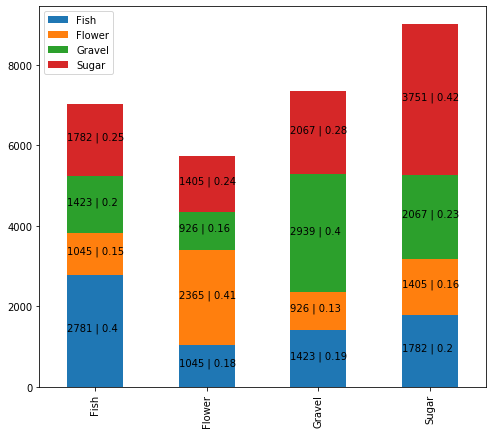

time: 187 ms


In [22]:
ax = sum_matrix.plot(kind='bar', stacked='true', figsize=(8,7))

s = sum_matrix.sum().values
cnt=0

for idx, p in enumerate(ax.patches):
    idx+=1
    
    b = p.get_bbox()
    val = p.get_height()
    x_offset = -0.25

    annot = '{} | {:.2}'.format(int(val), val/s[cnt])
    ax.annotate(annot, ( (b.x0 + b.x1)/2 + x_offset, (b.y0 + b.y1)/2))
    
    cnt+=1
    if idx%4==0:
        cnt = 0


* Класс Sugar имеет с каждым отдельным классом наибольшую вероятность совместного присутствия на снимке. При визуализации масок и снимков посмотрю почему.

In [23]:
labels_df.corr()

,Fish,Flower,Gravel,Sugar
Fish,1.000000,-0.102750,-0.036661,-0.076238
Flower,-0.102750,1.000000,-0.239079,-0.151605
Gravel,-0.036661,-0.239079,1.000000,0.061175
Sugar,-0.076238,-0.151605,0.061175,1.000000


time: 5.77 ms


* Корреляции очень низкие. Наибольшая наблюдается между Flower Gravel, указывающая на обратную связь между ними. 

## Visualization

* В описании данных сказано, про имеющуюся черную область на снимках

`The images were downloaded from NASA Worldview. Three regions, spanning 21 degrees longitude and 14 degrees latitude, were chosen. The true-color images were taken from two polar-orbiting satellites, TERRA and AQUA, each of which pass a specific region once a day. Due to the small footprint of the imager (MODIS) on board these satellites, an image might be stitched together from two orbits. The remaining area, which has not been covered by two succeeding orbits, is marked black.`
https://www.kaggle.com/c/understanding_cloud_organization/data

* Надо проверить сколько таких снимков, и что с их масками

In [24]:

#Данный скрипт специально закаменчен, так как работает достаточно долго. Выяснилось, что все изображения, 
#имеют черную область, кроме одного с ImageID == 8bd81ce. 

# import multiprocessing as mp


# num_partitions = 10 # количество частей, на которые будет разбит df
# num_workers = 4 # количество процессов


# def parallelize_dataframe(df, func):
#     df_split = np.array_split(df, num_partitions)
#     pool = mp.Pool(num_workers)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

# def combine_columns(df):
#     df['HasBA'] = df['Images'].apply(lambda img: has_black_area(img))
#     return df

# df_result = parallelize_dataframe(df_by_id, combine_columns)


time: 3.94 ms


### Check rle2mask

[INFO] img_name: 0091591.jpg
[INFO] shape: (1400, 2100, 3)
[INFO] count_mask: 3
[INFO] labels: ['Fish', 'Flower', 'Gravel', 'Sugar']


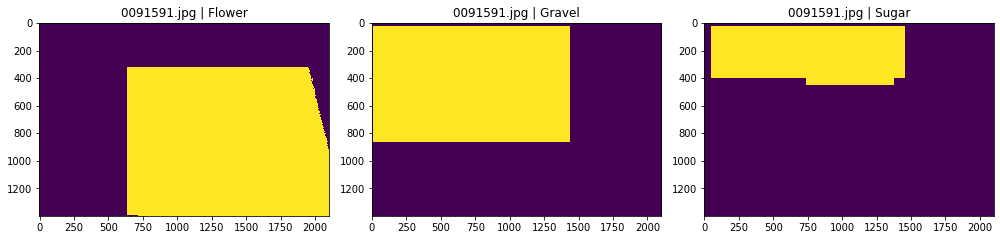

time: 785 ms


In [25]:
tst_data = df_by_id.iloc[10]

img_name = np.unique([i.split('_')[0] for i in tst_data.Images])[0]
img_path = os.path.join(train_images, img_name)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

labels = [i.split('_')[-1] for i in tst_data.Images]
mask_rle = {l:rows for l, rows in zip(labels, tst_data.EncodedPixels) if isinstance(rows, str)}
print(f'[INFO] img_name: {img_name}')
print(f'[INFO] shape: {img.shape}')
print(f'[INFO] count_mask: {len(mask_rle)}')
print(f'[INFO] labels: {labels}')

fig, axs = plt.subplots(nrows=1, ncols=len(mask_rle), figsize=(14,10))

for (k, v), ax  in zip(mask_rle.items(), axs.flat):

    mask = rle2mask(v, img.shape)

    ax.imshow(mask)
    ax.set_title('{} | {}'.format(img_name, k))



    plt.tight_layout()


* По какой-то причине маска у Flower имеется шум, вероятно этот шум был спровоцирован сенсором спутника MODIS.


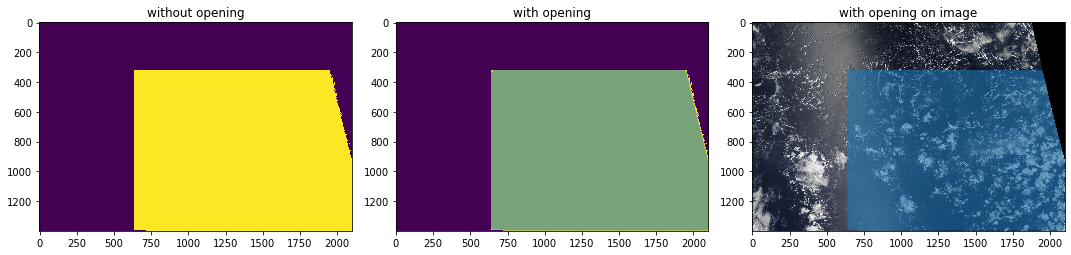

time: 794 ms


In [26]:
# Использую открытие для того, чтобы удалить шумы, которые образуются на краю с черной областью
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

mask_flower = mask_rle['Flower']
mask = rle2mask(mask_flower, img.shape)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), 
                               iterations=10)
cnts_original = mask2contour(mask)
cnts_opening = mask2contour(opening)
for cnt_or, cnt_op in zip(cnts_original, cnts_opening):
    poly_original = Polygon(cnt_or, alpha=0.6, linestyle="dashed", linewidth=2)
    poly_opening = Polygon(cnt_op, alpha=0.6, linestyle="dashed", linewidth=2)
    poly_img = Polygon(cnt_op, alpha=0.6, linestyle="dashed", linewidth=2)

    axs[0].add_patch(poly_original)
    axs[1].add_patch(poly_opening)
    axs[2].add_patch(poly_img)

axs[0].imshow(mask)
axs[0].set_title('without opening')

axs[1].imshow(mask)
axs[1].set_title('with opening')

axs[2].imshow(img)
axs[2].set_title('with opening on image')
plt.tight_layout()

* без открытия функция findCounters из opencv не может обнаружить контуры на оригинальной маске.
* Это нужно только для визуализации композита (снимка+маски).

###  Check visualize composition

Создам функцию `show_img_mask`, которая будет принимать на вход series и выводить изображения с масками, и подписями

[INFO] img_name: 29eebca.jpg
[INFO] shape: (1400, 2100, 3)
[INFO] count_mask: 2
[INFO] labels: ['Gravel', 'Sugar']


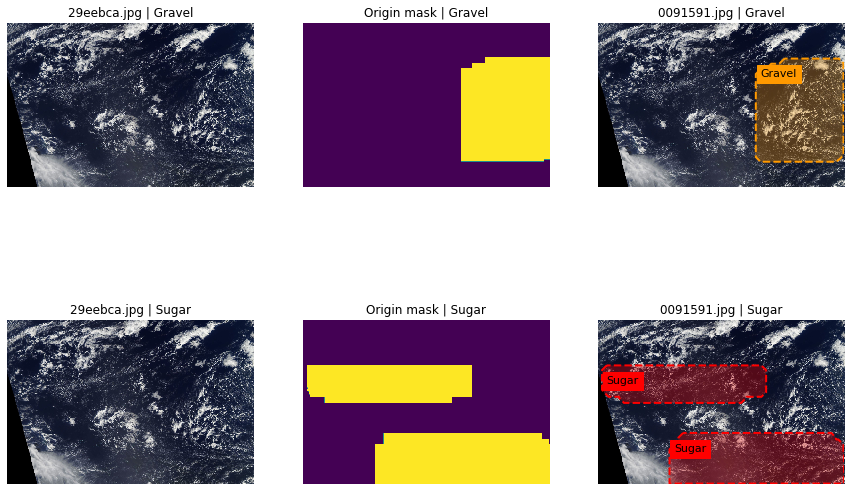

time: 384 ms


In [27]:
intresting_img = df_by_id[df_by_id['CountMask'] == 2]
total = len(intresting_img.index)

random = np.random.randint(total)
series = intresting_img.iloc[random]
show_img_mask(series)

* Какая-то очень странная разметка: Gravel Sugar почти идентичные границы имеют.

# Model

* Позаимствовал у https://www.kaggle.com/shahules/understanding-clounds-with-keras-unet

## DataGenerator

In [58]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, target_df, mode='fit',
                 base_path='understanding_cloud_organization/train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))

        info = []
        # Generate data
        for i, ID in enumerate(list_IDs_batch):

            img_srs = self.target_df.loc[ID]
            im_name = img_srs.ImageID
            img_path = f"{self.base_path}/{im_name}.jpg"
            
            if self.n_channels == 3:
                img = self.__load_rgb(img_path)
            else:
                img = self.__load_grayscale(img_path)
            
            if self.reshape is not None:
                img = cv2.resize(img, self.reshape[::-1])
            
            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)
            
            # Store samples
            X[i,] = img
            
            #Info samples
            
        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            
            image_srs = self.target_df.loc[ID]
            
            rles = image_srs.EncodedPixels
            
            if self.reshape is not None:
                masks = build_mask(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_mask(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

time: 4.99 ms


In [59]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

time: 1.16 ms


In [60]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

time: 912 µs


## Train

In [61]:
df_test_train = df_by_id.reset_index()
train = df_test_train.sample(frac=0.7,random_state=200) #random state is a seed value
val = df_test_train.drop(train.index)

time: 4.99 ms


In [62]:
# Params
BATCH_SIZE = 2
BACKBONE = 'resnet18'
ACTIVATION = 'sigmoid'
EPOCHS = 4
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
ES_PATIENCE = 5 #Прерывание обучения, когда точность не улучшается в течение 5 эпох
RLROP_PATIENCE = 3 # Произведение вызова, когда потери на проверочных данных не улучшаются в течение 3 эпох
RLROP_FACTOR = 0.1 # Уменьшение скорости обучения в 10 раз
N_CLASSES = 4
VERBOSE = 1
OPTIMIZER='adam'

time: 700 µs


In [63]:
callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            patience=ES_PATIENCE
        ),
        ModelCheckpoint(
            filepath=f'cloud_organization-{str(datetime.now())}.h5',
            monitor='val_loss',
            save_best_only=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            patience=RLROP_PATIENCE,
            factor=RLROP_FACTOR
        )    
    ]

time: 579 µs


In [64]:
train_gen = DataGenerator(train.index, 
                        target_df=train, 
                        reshape=(HEIGHT, WIDTH),
                        n_classes=N_CLASSES,
                        n_channels=CHANNELS,
                        batch_size=BATCH_SIZE)

val_gen = DataGenerator(val.index, 
                        target_df=val, 
                        reshape=(HEIGHT, WIDTH),
                        n_classes=N_CLASSES,
                        n_channels=CHANNELS,
                        batch_size=BATCH_SIZE)

time: 4.2 ms


In [65]:
#! pip install segmentation-models

time: 278 µs


In [66]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing

# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = get_preprocessing(BACKBONE) 

model = Unet(BACKBONE, input_shape=(HEIGHT, WIDTH, CHANNELS), 
                classes=N_CLASSES, activation=ACTIVATION)

model.compile(optimizer=OPTIMIZER, loss=bce_dice_loss, 
              metrics=[dice_coef])

time: 3.32 s


In [3]:
history=model.fit_generator(train_gen,
                            validation_data=val_gen, 
                            epochs=EPOCHS,
                            verbose=VERBOSE, 
                            callbacks=callbacks_list)

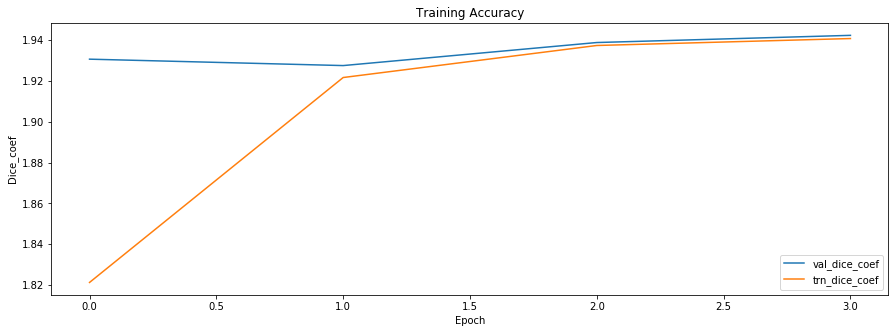

time: 196 ms


In [38]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Dice_coef')
plt.legend(); 
plt.show()